In [1]:
import numpy as np
from sklearn.decomposition import PCA
import h5py
import pickle
import matplotlib.pyplot as plt
import GPy

In [2]:
def gp_predict(model, params):
    """
    Predicts the weights matrix to feed inverse PCA from physical parameters.

    Input :
    - model : GP model
    - params : physical parameters (flux, radius, shear profile, psf fwhm)

    Output :
    - predic[0] : predicted weights
    """
    predict = model.predict(params)
    return predict[0]


def emulator(pca_model, gp_model, params):
    """
    Emulates new images from physical parameters.

    Input :
    - pca : PCA model
    - gp_model : GP model
    - params : physical parameters (flux, radius, shear profile, psf fwhm)

    Output :
    - reconstructed : Emulated image
    """
    # Weights prediction
    params = np.expand_dims(params, axis = 0)
    pred_weights = gp_predict(gp_model, params)

    # Inverse PCA (pred_weights * basis + mean)
    reconstructed = pca_model.inverse_transform(pred_weights)
    return reconstructed


In [3]:
save_loc = "/Users/nramachandra/Desktop/Projects/AGNfinder/FSPS/"

with h5py.File(save_loc + 'fsps_cache.hdf5', 'r') as f:
   X_loaded = f['fsps_cache']['X'][...]
   Y_loaded = f['fsps_cache']['Y'][...] 


In [4]:
## logging and clipping
# X_loaded = np.log10(X_loaded)
Y_loaded = np.log10(Y_loaded[:, 100:])

# ### rescaling 
y_mean = np.mean(Y_loaded, axis=0)
y_mult = np.max(Y_loaded - y_mean, axis=0)

y_train = (Y_loaded - y_mean)/y_mult

# ### rescaling 
x_mean = np.mean(X_loaded, axis=0)
x_mult = np.max(X_loaded - x_mean, axis=0)

x_train = (X_loaded - x_mean)/x_mult

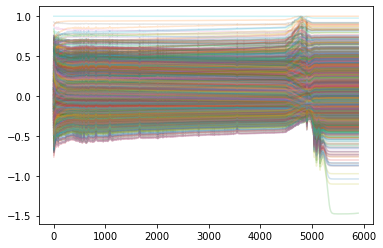

In [5]:

plt.plot(y_train.T, alpha = 0.2)
# plt.yscale('log')
# plt.xscale('log')
plt.show()

## loading trained GP and PCA models

In [6]:
num_params = 3
num_bases = 10

with open('pcaModel.pickle', 'rb') as handle:
    pca_model = pickle.load(handle)

gp_model = GPy.models.GPRegression.load_model('gpfit_'+str(num_bases)+'_'+str(num_params) + '.zip')

In [14]:
emulator(pca_model, gp_model, x_train[22])

array([[ 0.20480842,  0.20031205,  0.19513907, ..., -0.06307181,
        -0.06307187, -0.06307193]])

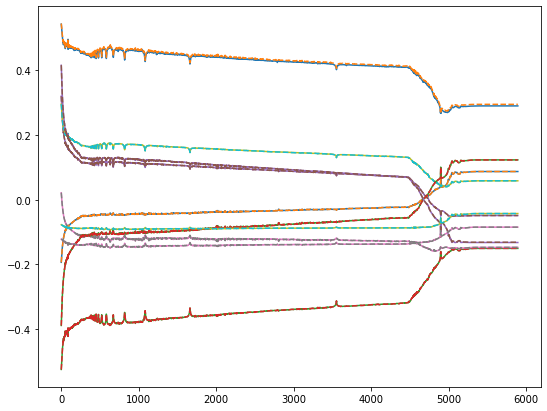

In [23]:
plt.figure(1212, figsize = (9, 7))
for i in range(10):
    rand_idx = (np.random.randint(100, 2000))
    rand_params = x_train[rand_idx]
    y_emu = emulator(pca_model, gp_model, rand_params)[0]
    y_true = y_train[rand_idx]
    plt.plot(y_emu.T/y_true.T)
    plt.plot(y_emu.T)
    plt.plot(y_true.T, '--')

    
plt.show()

In [16]:
x_train[23]

array([0.67034251, 0.28784201, 0.01118953])